In [173]:
import sys
import os
import pandas as pd
from pathlib import Path

pwd  = Path(os.getcwd())
sys.path.append(str(pwd.parent)) # needed to use "koray" module
from koray.feature_calculation.util import get_features

seed = 42

conference_invitations = ['ICLR.cc/2023/Conference/-/Blind_Submission']

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed=seed)
feature_df = list(get_features(conference_invitations, disable_cache=True))
df = pd.concat(feature_df)

Calculating features for ICLR.cc/2023/Conference/-/Blind_Submission (1/1)
✔ Successfully loaded dataframes


100%|██████████| 3796/3796 [00:16<00:00, 236.00it/s]
/Users/busraasan/codes/data-literacy-group16/koray/feature_calculation/paper_features.py:131: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.feature_df[col] = self.feature_df[col].astype(dtype)
/Users/busraasan/codes/data-literacy-group16/koray/feature_calculation/paper_features.py:131: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.feature_df[col] = self.feature_df[col].astype(dtype)
/Users/busraasan/codes/data-literacy-group16/koray/feature_calculation/paper_features.py:131: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.feature_df[col] = self.feature_df[col].astype(dtype)
/Users/busraasan/codes/data-literacy-group16/koray/featu

✔ Successfully calculated features


In [174]:
df["paper_area"].value_counts()

paper_area
Deep Learning and representational learning                                                                              1114
Applications (eg, speech processing, computer vision, NLP)                                                                496
Reinforcement Learning (eg, decision and control, planning, hierarchical RL, robotics)                                    457
Social Aspects of Machine Learning (eg, AI safety, fairness, privacy, interpretability, human-AI interaction, ethics)     343
General Machine Learning (ie none of the above)                                                                           248
Machine Learning for Sciences (eg biology, physics, health sciences, social sciences, climate/sustainability )            210
Theory (eg, control theory, learning theory, algorithmic game theory)                                                     200
Unsupervised and Self-supervised learning                                                                  

In [175]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering, KMeans

# Load model and encode keywords
model = SentenceTransformer('all-mpnet-base-v2')  # Choose a suitable model

def split_and_normalize(kw_string):
    if pd.isna(kw_string):
        return []
    tokens = kw_string.split(";")
    return [t.strip().lower() for t in tokens if t.strip()]


topic_to_cluster1 = "Applications (eg, speech processing, computer vision, NLP)"
topic_to_cluster2 = "Deep Learning and representational learning"

idx_list_for_topic = df[(df["paper_area"] == topic_to_cluster1) | (df["paper_area"] == topic_to_cluster2)].index.tolist()

filtered_df = df.loc[idx_list_for_topic]

all_keywords = list(set(
    keyword
    for keywords in filtered_df["keywords"]
    if isinstance(keywords, list)
    for keyword in keywords
))

embeddings = model.encode(all_keywords)

In [176]:
# Clustering
clustering = KMeans(n_clusters=30, random_state=seed)  # Adjust threshold
clusters = clustering.fit_predict(embeddings)

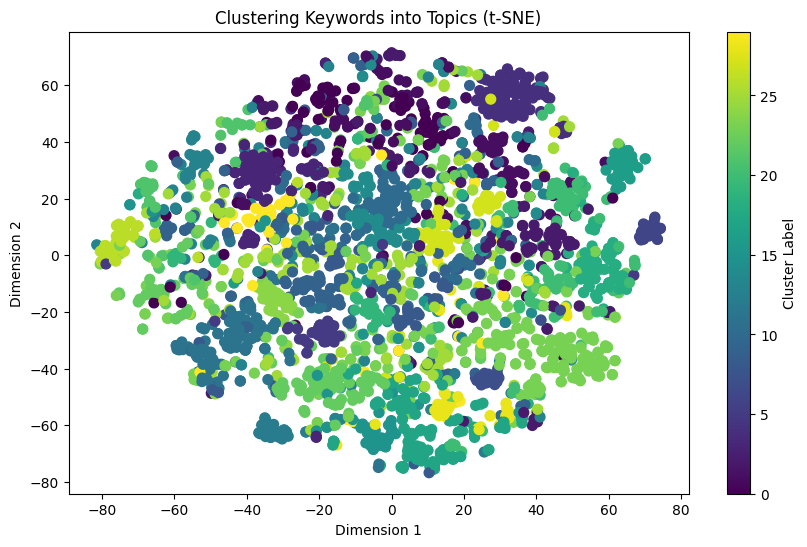

In [177]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=seed)
reduced_embeddings = tsne.fit_transform(embeddings)

# 2. Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.title('Clustering Keywords into Topics (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [178]:
for i, keyword in enumerate(all_keywords):
    if clusters[i] == 2:
        print(keyword)


Imgae Restoration； Low-Level Vision
Face Restoration
weight interpolation
Image Super-Resolution
Feature Augmentation
separate surrogate gradient path
sketch healing
Fast Channel squeezing
numerical interpolation
fine-grained structured sparsity
Randomized Smoothing
blending
Speech enhancement
sparsity.
image de-raining
distortion of pre-trained models
magnetic resonance imaging
over-smoothing
Loss function
Quantization
perturbation defocusing
feature space interpolation
low-light image enhancement
noise suppression
GNN denoising
differentiable temporal resolution
Bi-Encoder
Compression
compressed sensing
smoothing
label smoothing
batch label restoration
Multichannel speech enhancement
Automatic Augmentation
gradient estimation
Auto-encoder.
Image denoising
feature augmentation
Information-Theoretic Steganography
Old Photo Restoration
post-training quantization
Gradient regularization
deep image prior
Compressed Sensing
Saturation
Generalizable human radiance fields
Digital Signal Proc

### Cosine Similarity for Clustering Topics based on Anchor Vectors

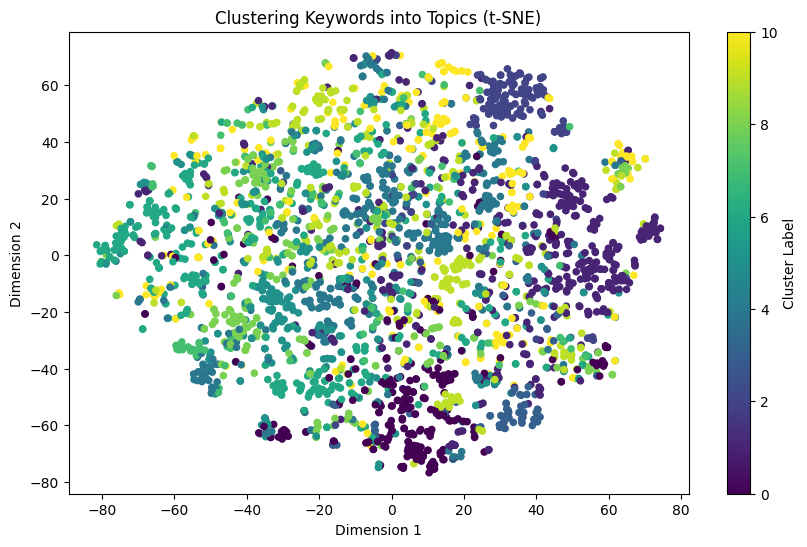

In [179]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import numpy as np

anchor_vectors = {
    "NLP": ["nlp", "language", "language modeling", "llm", "retrieval", "few shot", "gpt-3"],
    "computer vision": ["NeRF", "vision", "image", "object detection", "vision transformer", "video", "point clouds", "3d", "segmentation", "cnn", "clip"],
    "GNN": ["gnn", "graph", "graph neural networks", "graph convolutional networks", "graph representation learning"],
    "speech processing": ["speech", "audio", "speaker", "speech synthesis"],
    "representation learning": ["representation learning", "self-supervised", "contrastive", "pre-training", "unsupervised", "supervised", "pca"],
    "domain adaptation": ["domain adaptation", "domain generalization", "transfer learning", "domain"],
    "trustworthy AI": ["fairness", "bias", "ethics", "trustworthy", "interpretability", "explainability", "XAI", "pruning", "robustness", "adversarial", "privacy", "security"],
    "federated learning": ["federated learning", "privacy", "secure", "decentralized", "distributed"],
    "reinforcement learning": ["reinforcement learning", "RL", "policy", "reward", "actor-critic", "Q-learning"],
    "generative models": ["generative models", "GAN", "VAE", "generative adversarial networks", "variational autoencoder", "diffusion models", "diffusion"],
    "other":["molecule", "disease", "temporal"]
}

data_points = embeddings

all_distances = []
anchor_idx_list = []
for key in anchor_vectors:
    embedded_anchors = model.encode(anchor_vectors[key])
    anchor_idx_list.append(embedded_anchors.shape[0])
    distances = np.max(cosine_similarity(data_points, embedded_anchors), axis=1)
    all_distances.append(distances)

#cluster_assignments = np.argmax(all_distances, axis=0)

max_values = np.max(all_distances, axis=0)
threshold = 0.25
cluster_assignments = np.argmax(all_distances, axis=0)
cluster_assignments[max_values < threshold] = len(anchor_vectors)-1

plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_assignments, cmap='viridis', s=20)

plt.colorbar(label='Cluster Label')
plt.title('Clustering Keywords into Topics (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [180]:
word_clusters = {
    "nlp": [],
    "computer vision": [],
    "gnn": [],
    "speech processing": [],
    "representation learning": [],
    "domain adaptation": [],
    "trustworthy AI": [],
    "federated learning": [],
    "reinforcement learning": [],
    "generative models": [],
    "other": []
}

fine_grained_area_code = {
    0: "nlp",
    1: "computer vision",
    2: "gnn",
    3: "speech processing",
    4: "representation learning",
    5: "domain adaptation",
    6: "trustworthy AI",
    7: "federated learning",
    8: "reinforcement learning",
    9: "generative models",
    10: "other"
}

for i, keyword in enumerate(all_keywords):
    word_clusters[fine_grained_area_code[cluster_assignments[i]]].append(keyword)


### Re-asign paper areas based on new clusters

In [181]:
if "cluster" not in df.columns:
    df["paper_area_fine_grained"] = None

for index in idx_list_for_topic:
    paper_keywords = df["keywords"]
    if pd.isna(paper_keywords):
        continue
    else:
        for key in anchor_vectors:
            df.at[index, "paper_area_fine_grained"] = 


SyntaxError: invalid syntax (660717215.py, line 10)